In [143]:
print(python_version(), joblib.cpu_count())

3.8.5 16


In [3]:
import sys
import pandas as pd
import numpy as np
import random
import pyspark
import time 
import itertools
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import pickle
import statsmodels.api as sm

from collections import Counter

from math import sqrt
from platform import python_version

from pyspark.sql import SparkSession
from pyspark.sql import functions as f
#from pyspark.mllib.feature import MDLPDiscretizer
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.linalg import Vectors

import joblib
from joblib import parallel_backend
from joblib import Parallel, delayed

from pandas_profiling import ProfileReport

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
#from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score, r2_score, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from optbinning import OptimalBinning
from optbinning import MDLP
from optbinning import BinningProcess
from optbinning.binning.transformations import transform_event_rate_to_woe
from optbinning.binning.metrics import gini
from optbinning.binning.outlier import ModifiedZScoreDetector

#plt.style.use('seaborn')    
#plt.style.use('default') 

In [4]:
target = 'TARGET'
variables = ['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'EXT_SOURCE_3']
def prepare_df(df_spark, variables = variables, 
               remove_outl = True, remove_na = True):
    '''just ulpoad and creates the initial df from previously uploaded spark d0'''
    df0 = df_spark.select(variables + [target]).toPandas()
    df0.DAYS_EMPLOYED.replace(365243, np.nan, inplace=True)
    print(f'df initial shape: {df0.shape}\n')
    if remove_na:
        df = df0.dropna(axis=0).reset_index(drop = True)
        print(f'df shape after processing missing values: {df.shape}\n')
    else: 
        df = df0
    outl = ModifiedZScoreDetector(3.5)
    if remove_outl:
        for variable in variables:
            outl.fit(df[variable])
            df = df[~outl.get_support()]
            print(f'N outliers in {variable}: {outl.get_support().sum()},\
            df shape after outlier removal: {df.shape}')
        df = df.reset_index(drop = True)
    print(f'\nfinal df shape: {df.shape}')
    # we remove nan not to spent time for different method API's
    return df

In [2]:
spark = SparkSession.builder.master("local").appName("spark_app_1234").getOrCreate()

sc = spark.sparkContext
spark

21/11/18 08:42:18 WARN Utils: Your hostname, MacBook-Pro-16-Andrei.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
21/11/18 08:42:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/18 08:42:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/18 08:42:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
spark.sparkContext.getConf().getAll()

In [5]:
d0 = (
    spark
    .read
    .format("csv") 
    .option("header","true") 
    .option("inferSchema","true") 
    .load("/Users/AM/home-credit-default-risk/application_train.csv")
)


In [6]:
variables = ['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'EXT_SOURCE_3']
variables_wide = variables + ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'REGION_POPULATION_RELATIVE', 
                              'OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
                              'DAYS_ID_PUBLISH','CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1',
                              'EXT_SOURCE_2', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG',
                              'ENTRANCES_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 
                              'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                              'YEARS_BUILD_MODE', 'LIVINGAREA_MODE', 'APARTMENTS_MEDI',
                              'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                              'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR']
df = prepare_df(d0, variables_wide, remove_outl=False, remove_na=False)

21/11/18 08:45:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


df initial shape: (307511, 32)


final df shape: (307511, 32)


In [7]:
df_dea = ProfileReport(df)


In [8]:
df_dea.to_file('df_dea_wide.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/AM/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
d.select(f.sum("TARGET").alias('Total target')).show()

In [ ]:
d.select('AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'TARGET')\
    .describe().show()

In [75]:
df = d0.select('AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'TARGET')\
    .toPandas()

## Binning sbx

### upload

<AxesSubplot:>

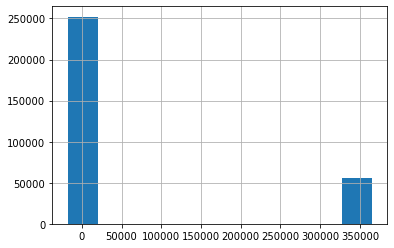

In [231]:
df.DAYS_EMPLOYED.hist()

<AxesSubplot:>

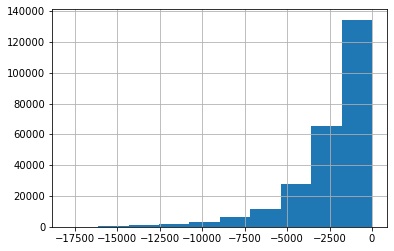

In [76]:
df.DAYS_EMPLOYED.replace(365243, np.nan, inplace=True)
df.DAYS_EMPLOYED.hist()

In [77]:
variable = "AMT_GOODS_PRICE"
x = df[variable].values
y = df.TARGET

In [234]:
optb = OptimalBinning(name=variable, dtype="numerical")
#optb = OptimalBinning(variable)
optb.fit(x, y)
optb.status


'OPTIMAL'

In [235]:
optb.splits

array([ 158283.  ,  206266.5 ,  283083.75,  407362.5 ,  450117.  ,
        677889.  ,  902371.5 , 1272687.75])

In [20]:
binning_table = optb.binning_table
binning_table.build() # it prints out


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 158283.00)",27665,0.089964,25819,1846,0.066727,0.205604,0.003490,4.354743e-04
1,"[158283.00, 206266.50)",17225,0.056014,15787,1438,0.083483,-0.036552,0.000076,9.498700e-06
2,"[206266.50, 283083.75)",55555,0.180660,50872,4683,0.084295,-0.047112,0.000409,5.111800e-05
3,"[283083.75, 407362.50)",28384,0.092302,25466,2918,0.102804,-0.26604,0.007305,9.103978e-04
4,"[407362.50, 450117.00)",29150,0.094793,25132,4018,0.137839,-0.599128,0.043706,5.382927e-03
5,"[450117.00, 677889.00)",68896,0.224044,63572,5324,0.077276,0.047463,0.000495,6.184006e-05
6,"[677889.00, 902371.50)",38480,0.125134,36043,2437,0.063332,0.261459,0.007670,9.560082e-04
7,"[902371.50, 1272687.75)",25757,0.083760,24303,1454,0.056451,0.383796,0.010517,1.306574e-03
8,"[1272687.75, inf)",16121,0.052424,15435,686,0.042553,0.68103,0.018366,2.252372e-03
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


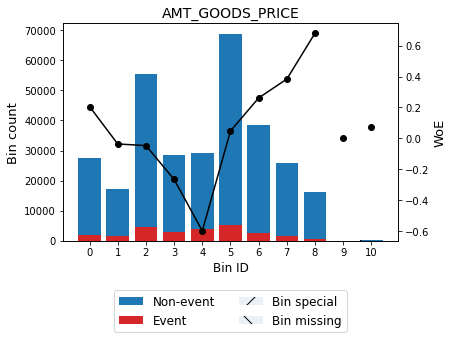

In [79]:
binning_table.plot()

In [ ]:
optb.information(print_level=1)

In [91]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16285100
    IV (Jeffrey)             0.09203683
    JS (Jensen-Shannon)      0.01136678
    Hellinger                0.01143507
    Triangular               0.04493527
    KS                       0.09419178
    HHI                      0.13699374
    HHI (normalized)         0.05069311
    Cramer's V               0.08540430
    Quality score            0.09300179

  Monotonic trend                  peak

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]     P[B > A]
        0      1    43.958385  3.354323e-11 2.114759e-15 1.000000e+00
        1      2     0.112416  7.374106e-01 3.667932e-01 6.332068e-01
        2      3    78.152151  9.540170e-19 8.691168e-32 1.000000e+00
        3      4   166.487975  4.327866e-38 1.297878e-55 1.000000e+00
        4      5   871.54996

In [ ]:
optb2 = OptimalBinning(name=variable, dtype="numerical",  monotonic_trend="descending")
optb2.fit(x, y)
optb2.status

In [ ]:
binning_table2 = optb2.binning_table
binning_table2.build()
binning_table2.plot()

### MDLP

In [477]:
df = d0.select('AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'TARGET').toPandas()

In [478]:
df.DAYS_EMPLOYED.replace(365243, 1000, inplace=True)
#df.DAYS_EMPLOYED.hist()


In [479]:
variable = "DAYS_EMPLOYED"
x = df[variable].dropna().values
y = df.TARGET
optb_MDLP = MDLP()
optb_MDLP.fit(x, y)
optb_MDLP
optb_MDLP.splits

array([-1.45405000e+04, -1.29121800e+04, -5.46965065e+03, -3.95795742e+03,
       -3.09101371e+03, -2.40349790e+03, -1.78351355e+03, -1.40623290e+03,
       -9.65244032e+02, -1.04812581e+02, -2.55056452e+01, -1.71548387e+00,
        0.00000000e+00])

In [452]:
x

array([ -637, -1188,  -225, ..., -7921, -4786, -1262], dtype=int32)

In [442]:
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int32

In [468]:
optb_MDLP = MDLP()
optb_MDLP.fit(x, y)
optb_MDLP
optb_MDLP.splits

array([-1.45405000e+04, -1.29121800e+04, -5.46965065e+03, -3.95795742e+03,
       -3.09101371e+03, -2.40349790e+03, -1.78351355e+03, -1.40623290e+03,
       -9.65244032e+02, -1.04812581e+02, -2.55056452e+01, -1.71548387e+00,
        0.00000000e+00])

In [455]:
optb_MDLP.get_params()

{'max_candidates': 32, 'min_samples_leaf': 2, 'min_samples_split': 2}

## Scikit-learn

In [407]:
df = d0.select('AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'TARGET')\
    .toPandas()

In [ ]:
df[variable].isna().sum()

In [408]:
variable = "AMT_GOODS_PRICE"
df[variable] = df[variable].replace(np.nan,-1)
x = df[variable].values.reshape(-1,1)
y = df.TARGET

In [412]:
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile').fit(x)
est.bin_edges_[0]

array([-1.000e+00,  2.250e+05,  3.735e+05,  5.220e+05,  8.145e+05,
        4.050e+06])

In [ ]:
est.bin_edges_[0]

In [50]:
df[variable].isna().sum()

278

## Pipeline to show effect in prediction

In [123]:
def bin_table(dataframe, disc_var_name, target_var_name, edges):
    '''
    returns the analogue of optb.binning_table (plus Gini) based on edges 
    df - our data in DataFrame, target_var_name - target variable
    disc_var_name - variable to analyze
    edges - bin edges 
    returns WoE DataFrame
    also puts all NA into a separate bin (to keep info as I wrote in FP paper)
    '''
    df = dataframe.copy()
    edges = np.append(edges, np.inf)
    edges = np.insert(edges, 0, -np.inf)
    N_na = df[disc_var_name].isna().sum()
    target_share_in_na = df[target][df[disc_var_name].isna()].sum() / N_na

    df['Bin'] = pd.cut(df[disc_var_name],  bins = edges) 
    df = pd.concat([df['Bin'], df[target_var_name]], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], 
                               as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], 
                               as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    if N_na > 0: 
        df.loc[df.shape[0]] = ['Missing', N_na, target_share_in_na]  # adding na observations
    df.columns = [df.columns.values[0], 'N_obs', 'prop_pos']
    df['N_obs'] = df['N_obs']
    df['Count (%)'] = (100*df['N_obs'] / df['N_obs'].sum()).round(2)
    df['N_pos'] = (df['prop_pos'] * df['N_obs'])
    df['N_neg'] = ((1 - df['prop_pos']) * df['N_obs'])
    df['Event_rate'] = df['N_pos'] / df['N_obs']
    df['Non_event_rate'] = df['N_neg'] / df['N_obs']
    df['prop_N_pos'] = df['N_pos'] / df['N_pos'].sum()
    df['prop_N_neg'] = df['N_neg'] / df['N_neg'].sum()
    df['Odds'] = df['Event_rate'] / df['Non_event_rate']
    df['WoE'] = -np.log(df['prop_N_pos'] / df['prop_N_neg']) 
    df['diff_prop_pos'] = df['prop_pos'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = -(df['prop_N_pos'] - df['prop_N_neg']) * df['WoE']
    df['Gini'] = ''
    df = df[['Bin', 'N_obs', 'Count (%)', 'N_neg', 'N_pos', 
             'Event_rate', 'WoE', 'IV', 'Gini', 'Odds']]
    df.loc['Total']= df.sum(numeric_only=True, axis=0)
    df.columns = ['Bin', 'Count', 'Count (%)', 'Non_event', 'Event', 
                  'Event_rate', 'WoE', 'IV', 'Gini', 'Odds']   
    df.loc['Total', 'Gini'] = gini(df.Event[:-1], df.Non_event[:-1])
    df.loc['Total', 'Event_rate'] = ""
    df.loc['Total', 'WoE'] = ""
    #df.loc['Total', 'Bin'] = "" # set the category first
    df.loc['Total', 'Odds'] = ""
    return df

In [334]:
# let's build the binning_table made by OptimalBINNING
df = d0.select('AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'TARGET')\
    .toPandas()
variable = "AMT_GOODS_PRICE"
x = df[variable].values
y = df.TARGET
optb = OptimalBinning(name=variable, dtype="numerical")
optb.fit(x, y)
edges = optb.splits
optb.status


'OPTIMAL'

In [67]:
binning_table = optb.binning_table
binning_table.build() # it prints out


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -5443.50)",23768,0.077292,22704,1064,0.044766,0.62802,2.352265e-02,2.892944e-03
1,"[-5443.50, -3923.50)",21519,0.069978,20313,1206,0.056043,0.391466,9.112185e-03,1.131805e-03
2,"[-3923.50, -3075.50)",20997,0.068280,19652,1345,0.064057,0.2493,3.824150e-03,4.767847e-04
3,"[-3075.50, -2447.50)",22332,0.072622,20732,1600,0.071646,0.129189,1.148255e-03,1.434322e-04
4,"[-2447.50, -1789.50)",29229,0.095050,26871,2358,0.080673,0.000748,5.320768e-08,6.650959e-09
5,"[-1789.50, -1404.50)",23254,0.075620,21096,2158,0.092801,-0.152584,1.877016e-03,2.343996e-04
6,"[-1404.50, -982.50)",30241,0.098341,27170,3071,0.101551,-0.252375,6.963599e-03,8.681472e-04
7,"[-982.50, -566.50)",34600,0.112516,30787,3813,0.110202,-0.343809,1.536358e-02,1.911044e-03
8,"[-566.50, inf)",46197,0.150229,40977,5220,0.112994,-0.371972,2.429573e-02,3.019578e-03
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00


In [217]:
# we can plot WOE
def woe_plot(df, rot_x_labels = 0):
    '''plots WoE from WoE_df'''
    x = np.array(df.iloc[:, 0].apply(str))
    y = df['WoE']
    plt.figure(figsize=(12, 8))
    plt.plot(x, y, marker = 'o', linestyle = '-', color = 'b')
    plt.xlabel(df.columns[0])
    plt.ylabel('WoE')
    plt.title(str('WoE for ' + df.columns[0]))
    plt.xticks(rotation = rot_x_labels)
    plt.show
#woe_plot(d.iloc[:-1,:], 45)

In [91]:
# we can build the same table based just on edges (from edges = optb.splits or other splits)
bt = bin_table(df, variable, target, edges)
bt

,Bin,Count,Count (%),Non_event,Event,Event_rate,WoE,IV,Gini,Odds
0,"(-inf, -5443.5]",23768.0,7.73,22704.0,1064.0,0.044766,0.62802,2.352265e-02,,0.046864
1,"(-5443.5, -3923.5]",21519.0,7.00,20313.0,1206.0,0.056043,0.391466,9.112185e-03,,0.059371
2,"(-3923.5, -3075.5]",20997.0,6.83,19652.0,1345.0,0.064057,0.2493,3.824150e-03,,0.068441
3,"(-3075.5, -2447.5]",22332.0,7.26,20732.0,1600.0,0.071646,0.129189,1.148255e-03,,0.077175
4,"(-2447.5, -1789.5]",29229.0,9.51,26871.0,2358.0,0.080673,0.000748,5.320768e-08,,0.087753
5,"(-1789.5, -1404.5]",23254.0,7.56,21096.0,2158.0,0.092801,-0.152584,1.877016e-03,,0.102294
6,"(-1404.5, -982.5]",30241.0,9.83,27170.0,3071.0,0.101551,-0.252375,6.963599e-03,,0.113029
7,"(-982.5, -566.5]",34600.0,11.25,30787.0,3813.0,0.110202,-0.343809,1.536358e-02,,0.123851
8,"(-566.5, inf]",46197.0,15.02,40977.0,5220.0,0.112994,-0.371972,2.429573e-02,,0.127389
9,Missing,55374.0,18.01,52384.0,2990.0,0.053996,0.430842,2.794658e-02,,0.057078


In [357]:
df_tmp[f'{variable}_WoE'][df_tmp[variable]<158283].values

array([0.20560399, 0.20560399, 0.20560399, ..., 0.20560399, 0.20560399,
       0.20560399])

In [245]:
# we can access IV and Gini from bin_tabla output
print(f'IV is {bt.iloc[-1, -2]}; Gini is {bt.iloc[-1, -1]}')


IV is 0.09203682939340666; Gini is 0.16285100177587897


In [246]:
# Bin column is an interval
160000 in bt.iloc[1,0]


True

In [249]:
# function to transform a variable into WOE
def WOE_transform_0(df, variable, target, edges):
    '''
    returns df with new column f'{variable}_woe' - WOE transormed variable
    first it uses bin_table function
    '''
    def find_WOE(x, btf, n_bins):
        result = btf.WoE[n_bins-1]
        for i in range(n_bins-1):
            if x in btf.Bin[i]: 
                result = btf.WoE[i]
                break      
        return result
    
    btf = bin_table(df, variable, target, edges)
    n_bins = btf.shape[0] - 1                
    df[f'{variable}_WOE'] = [find_WOE(x, btf, n_bins) for x in df[variable]]
    return df

def WOE_transform(df, variable, target, edges):
    '''
    optimized version
    returns df with new column f'{variable}_woe' - WOE transormed variable
    first it uses bin_table function
    '''  
    btf = bin_table(df, variable, target, edges)
    woe_index = np.searchsorted(edges, df[variable].values)
    df_tmp = df.copy()
    df_tmp[f'{variable}_WoE'] = [btf.WoE[i] for i in woe_index]
    tmp = btf.WoE[btf.shape[0]-2]
    df_tmp[f'{variable}_WoE'][df_tmp[variable].isna()] = tmp
    
    return df_tmp


In [ ]:
# the optimized verwion is ~9 times faster
t0 = time.time()
df_tmp = WOE_transform(df, variable, target, edges)
print(f'Run time is {time.time()-t0}')


In [376]:
df_tmp = df_tmp[~df_tmp[variable].isna()]
df_tmp.shape

(307233, 4)

In [374]:
fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp[f'{variable}_WoE'], pos_label=0)
g = (2 * auc(fpr, tpr) - 1) * 100
g

16.285100177587886

In [377]:
fpr, tpr, _ = roc_curve(df_tmp[target], df_tmp[f'{variable}'], pos_label=0)
g = (2 * auc(fpr, tpr) - 1) * 100
g

6.667536879224079

### Let's check the pipeline from the very beginning for the second variable


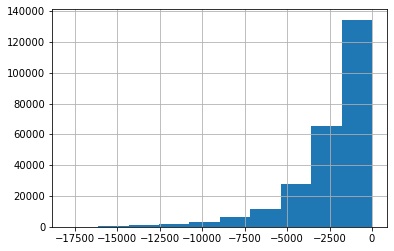

In [81]:
df1 = d0.select('DAYS_EMPLOYED', 'TARGET').toPandas()
variable = "DAYS_EMPLOYED"
target = 'TARGET'
df1.DAYS_EMPLOYED.replace(365243, np.nan, inplace=True)
df1.DAYS_EMPLOYED.hist()
x = df1[variable].values
y = df1.TARGET.values


In [ ]:
df1[variable].isna().sum()

In [82]:
optb = OptimalBinning(name=variable, dtype="numerical")
optb.fit(x, y)
edges = optb.splits
optb.status
binning_table = optb.binning_table
bt0 = binning_table.build() # it prints out
bt0

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -5443.50)",23768,0.077292,22704,1064,0.044766,0.62802,2.352265e-02,2.892944e-03
1,"[-5443.50, -3923.50)",21519,0.069978,20313,1206,0.056043,0.391466,9.112185e-03,1.131805e-03
2,"[-3923.50, -3075.50)",20997,0.068280,19652,1345,0.064057,0.2493,3.824150e-03,4.767847e-04
3,"[-3075.50, -2447.50)",22332,0.072622,20732,1600,0.071646,0.129189,1.148255e-03,1.434322e-04
4,"[-2447.50, -1789.50)",29229,0.095050,26871,2358,0.080673,0.000748,5.320768e-08,6.650959e-09
5,"[-1789.50, -1404.50)",23254,0.075620,21096,2158,0.092801,-0.152584,1.877016e-03,2.343996e-04
6,"[-1404.50, -982.50)",30241,0.098341,27170,3071,0.101551,-0.252375,6.963599e-03,8.681472e-04
7,"[-982.50, -566.50)",34600,0.112516,30787,3813,0.110202,-0.343809,1.536358e-02,1.911044e-03
8,"[-566.50, inf)",46197,0.150229,40977,5220,0.112994,-0.371972,2.429573e-02,3.019578e-03
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00


In [83]:
binning_table.analysis(pvalue_test="chi2")

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.18744463
    IV (Jeffrey)             0.11405379
    JS (Jensen-Shannon)      0.01414469
    Hellinger                0.01420036
    Triangular               0.05614171
    KS                       0.08503114
    HHI                      0.11288537
    HHI (normalized)         0.02417391
    Cramer's V               0.08302920
    Quality score            0.34901057

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    30.167696 3.962549e-08 1.116385e-09  1.000000
        1      2    12.099332 5.043989e-04 1.788546e-04  0.999821
        2      3     9.839480 1.708057e-03 7.036486e-04  0.999296
        3      4    14.556680 1.360056e-04 4.467022e-05  0.999955
        4      5    24.221859 8.585232e-07 4.723

In [241]:
#binning_table.plot()


In [244]:
#bt = bin_table(df1, variable, target, edges) 
#bt

In [86]:
# let's make WOE transformation
t0 = time.time()
df1_woe = WOE_transform(df1, variable, target, edges)
print(f'Run time is {time.time()-t0}')

Run time is 1.9916846752166748


/var/folders/l6/r1vg3v7s7t57x3f0r786wnhc0000gp/T/ipykernel_88319/474444592.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[f'{variable}_WoE'][df_tmp[variable].isna()] = tmp


In [87]:
# gini for WoE transformed variable
fpr, tpr, _ = roc_curve(df1_woe[target], df1_woe[f'{variable}_WoE'], pos_label=0)
g = (2 * auc(fpr, tpr) - 1) * 100
g

18.74446338921456

In [88]:
# gini for initial variable
df1_no_na = df1[~df1[variable].isna()]
fpr, tpr, _ = roc_curve(df1_no_na[target], df1_no_na[f'{variable}'], pos_label=0)
g = (2 * auc(fpr, tpr) - 1) * 100
g

-16.478199430841812

## Let's build the model
it should be a function of edges, variable list, target.   
Returns model metrics (IV, Gini, time)

# FP PIPELINE
Function of DF, Test/ Train split, N_Iterations, Binning type and parameters.   
Returns distribution of the model metrics, features metric

## Home credit dataset import

In [ ]:
df = pd.read_csv('/Users/AM/home-credit-default-risk/application_train.csv')

In [ ]:
df_test = pd.read_csv('/Users/AM/home-credit-default-risk/application_test.csv')